In [189]:
import numpy as np
import torch

from tqdm import tqdm
from matplotlib import pyplot as plt

%load_ext autoreload
%autoreload 2
# If GPUs available, select which to train on
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
from utils import generate_run_ID, load_trained_weights
from place_cells import PlaceCells
from trajectory_generator import TrajectoryGenerator
from model import RNN, Transformer
from trainer import Trainer
# Training options and hyperparameters
class Options:
    pass
options = Options()

options.save_dir = '/Users/julianyocum/Projects/transformer-grid-cells/models/'
options.n_steps = 5000      # number of training steps
options.batch_size = 100      # number of trajectories per batch
options.sequence_length = 20  # number of steps in trajectory
options.learning_rate = 1e-4  # gradient descent learning rate
options.Np = 512              # number of place cells
options.Ng = 4096             # number of grid cells
options.place_cell_rf = 0.12  # width of place cell center tuning curve (m)
options.surround_scale = 2    # if DoG, ratio of sigma2^2 to sigma1^2
options.RNN_type = 'RNN'      # RNN or LSTM
options.activation = 'relu'   # recurrent nonlinearity
options.weight_decay = 0   # strength of weight decay on recurrent weights
options.DoG = True            # use difference of gaussians tuning curves
options.periodic = False      # trajectories with periodic boundary conditions
options.box_width = 2.2       # width of training environment
options.box_height = 2.2      # height of training environment

# added
options.device = 'mps'

options.run_ID = generate_run_ID(options)
# If you've trained with these params before, will restore trained model
place_cells = PlaceCells(options)
if options.RNN_type == 'RNN':
    model = RNN(options, place_cells).to(options.device)
elif options.RNN_type == 'Transformer':
    model = Transformer(options, place_cells).to(options.device)
trajectory_generator = TrajectoryGenerator(options, place_cells)
trainer = Trainer(options, model, trajectory_generator)

# Load example weights stored on github
# weight_dir = options.save_dir + '/example_trained_weights.npy'
# load_trained_weights(model, trainer, weight_dir)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Restored trained model from /Users/julianyocum/Projects/transformer-grid-cells/models/RNN_steps_5000_sequence_20_batch_100_4096_relu_rf_012_DoG_True_periodic_False_lr_00001_weight_decay_0/most_recent_model.pth


In [190]:
train_sae = False

In [191]:
import umap

data = np.random.rand(100, 10)
reducer = umap.UMAP()
embedding = reducer.fit_transform(data)

/Users/julianyocum/anaconda3/envs/ganguli/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



In [199]:
# rate_map = np.load(f'{trainer.ckpt_dir}/rate_map.npy')
# rate_map_lores = np.load(f'{trainer.ckpt_dir}/rate_map_lores.npy')

# SAE rate map
rate_map = np.load(f'{trainer.ckpt_dir}/sae_rate_map.npy')
rate_map_lores = np.load(f'{trainer.ckpt_dir}/sae_rate_map_lores.npy')

# place cell baseline
# rate_map = np.load(f'{options.save_dir}placecell_baseline/rate_map.npy')
# rate_map_lores = np.load(f'{options.save_dir}placecell_baseline/rate_map_lores.npy')

In [200]:
rate_map.shape

(16384, 2500)

In [201]:
# generate 1500 points on a 6d torus and project into 4096 dimensions

def generate_torus_map(n_points, n_dimensions, m_dimensions=4096):
    """Generate n_points on a n_dimensions-dimensional torus
    and project them into m-dimensional space
    
    Args:
        n_points (int): Number of points to generate
        n_dimensions (int): Number of dimensions of the torus
        
    Returns:
        np.ndarray: Array of shape (n_points, 4096) containing projected torus points
    """
    # Generate random angles for each dimension of the torus
    angles = np.random.uniform(0, 2*np.pi, (n_points, n_dimensions))
    
    # Create the torus embedding (each dimension contributes sin and cos components)
    torus_embedding = np.zeros((n_points, 2 * n_dimensions))
    for i in range(n_dimensions):
        torus_embedding[:, 2*i] = np.cos(angles[:, i])
        torus_embedding[:, 2*i+1] = np.sin(angles[:, i])
    
    # Create random projection matrix to map from torus dimensions to 4096 dimensions
    # Using scaled random normal values for the mapping
    # projection_matrix = np.random.normal(0, 1/np.sqrt(2*n_dimensions), (2*n_dimensions, m_dimensions))
    
    # Project the torus points to 4096 dimensions
    projected_points = torus_embedding# @ projection_matrix
    
    return projected_points


torus_map = generate_torus_map(100, 6, 6)
torus_map = torus_map.T # to match rate_map shape

torus_map.shape

(12, 100)

In [202]:
def extract_central_square(rate_map, size_ratio=0.7):
    """Extract central square from each rate map to avoid edge artifacts"""
    res = int(np.sqrt(rate_map.shape[1]))
    center = res // 2
    half_size = int(res * size_ratio // 2)
    
    indices_i = np.arange(center - half_size, center + half_size)
    indices_j = np.arange(center - half_size, center + half_size)
    
    grid_i, grid_j = np.meshgrid(indices_i, indices_j)
    indices = np.ravel_multi_index((grid_i.flatten(), grid_j.flatten()), (res, res))
    
    return rate_map[:, indices]

In [203]:
rate_map.shape, extract_central_square(rate_map).shape

((16384, 2500), (16384, 1156))

In [204]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

central_rate_map = extract_central_square(rate_map)
# central_rate_map = torus_map
# central_rate_map = X.T
print(f"Original rate map shape: {rate_map.shape}, Central rate map shape: {central_rate_map.shape}")
# central_rate_map = g_sample

# PCA projection to reduce dimensionality (for computational efficiency)
pca_components = 6  # As suggested in the description
pca = PCA(n_components=pca_components)
rate_map_pca = pca.fit_transform(central_rate_map.T)
print(f"PCA projection shape: {rate_map_pca.shape}")
print(f"Explained variance: {np.sum(pca.explained_variance_ratio_) * 100:.2f}%")

Original rate map shape: (16384, 2500), Central rate map shape: (16384, 1156)
PCA projection shape: (1156, 6)
Explained variance: 29.10%


In [205]:
rate_map.shape

(16384, 2500)

Original rate map shape: (16384, 2500), Central rate map shape: (16384, 900)
PCA projection shape: (900, 7)
Explained variance: 35.52%
Computing persistent homology...


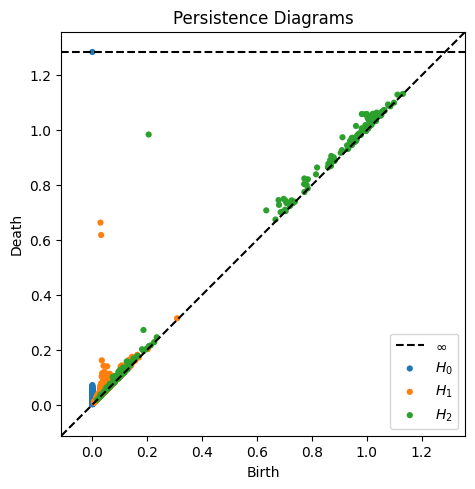

In [206]:
# Persitent homology

# Persistent homology
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from ripser import ripser
from persim import plot_diagrams

# Extract central portion of rate maps
central_rate_map = extract_central_square(rate_map, 0.6)
# central_rate_map = torus_map
# central_rate_map = X.T
print(f"Original rate map shape: {rate_map.shape}, Central rate map shape: {central_rate_map.shape}")
# central_rate_map = g_sample

# PCA projection to reduce dimensionality (for computational efficiency)
pca_components = 7  # As suggested in the description
pca = PCA(n_components=pca_components)
rate_map_pca = pca.fit_transform(central_rate_map.T)
print(f"PCA projection shape: {rate_map_pca.shape}")
print(f"Explained variance: {np.sum(pca.explained_variance_ratio_) * 100:.2f}%")

# Compute persistent homology using Ripser
print("Computing persistent homology...")
result = ripser(rate_map_pca, maxdim=2, metric='cosine', coeff=47) # paper uses coeff=47
diagrams = result['dgms']
# Also show the persistence diagrams
plt.figure()
plt.title("Persistence Diagrams")
plt.tight_layout()
plot_diagrams(diagrams, show=True, lifetime=False)

In [207]:
def plot_diagrams_and_barcodes(diagrams):
    # 4. Plot both diagrams and barcodes for H0, H1, and H2
    fig, axs = plt.subplots(2, 3, figsize=(15, 8))

    for i in range(3):
        # Plot persistence diagram for H0, H1, and H2 on the top row
        plot_diagrams(diagrams[i], ax=axs[0, i], show=False)
        axs[0, i].set_title(f"H{i} Persistence Diagram")
        
        # Plot barcode manually for H0, H1, and H2 on the bottom row
        # Sort by birth time instead of persistence
        bars = diagrams[i].copy()
        # Remove points with infinite death time for display purposes
        finite_idx = np.isfinite(bars[:, 1])
        if not np.all(finite_idx):
            # Set infinite values to a large number for display purposes
            max_finite = np.max(bars[finite_idx, 1]) if np.any(finite_idx) else 0
            bars[~finite_idx, 1] = 1 # max_finite * 10
        
        # Sort by birth time
        if i != 0:
            sorted_idx = np.argsort(bars[:, 0])[::-1]
        else:
            sorted_idx = np.arange(len(bars))
        
        for idx, j in enumerate(sorted_idx):
            birth, death = bars[j]
            if not np.isfinite(death):
                axs[1, i].plot([birth, axs[1, i].get_xlim()[1]], [idx, idx], 'k-')
            else:
                axs[1, i].plot([birth, death], [idx, idx], 'k-')
        
        axs[1, i].set_title(f"H{i} Barcode")
        axs[1, i].set_xlabel("Parameter value")
        axs[1, i].set_ylabel("Homology generators")

    plt.tight_layout()
    plt.show()

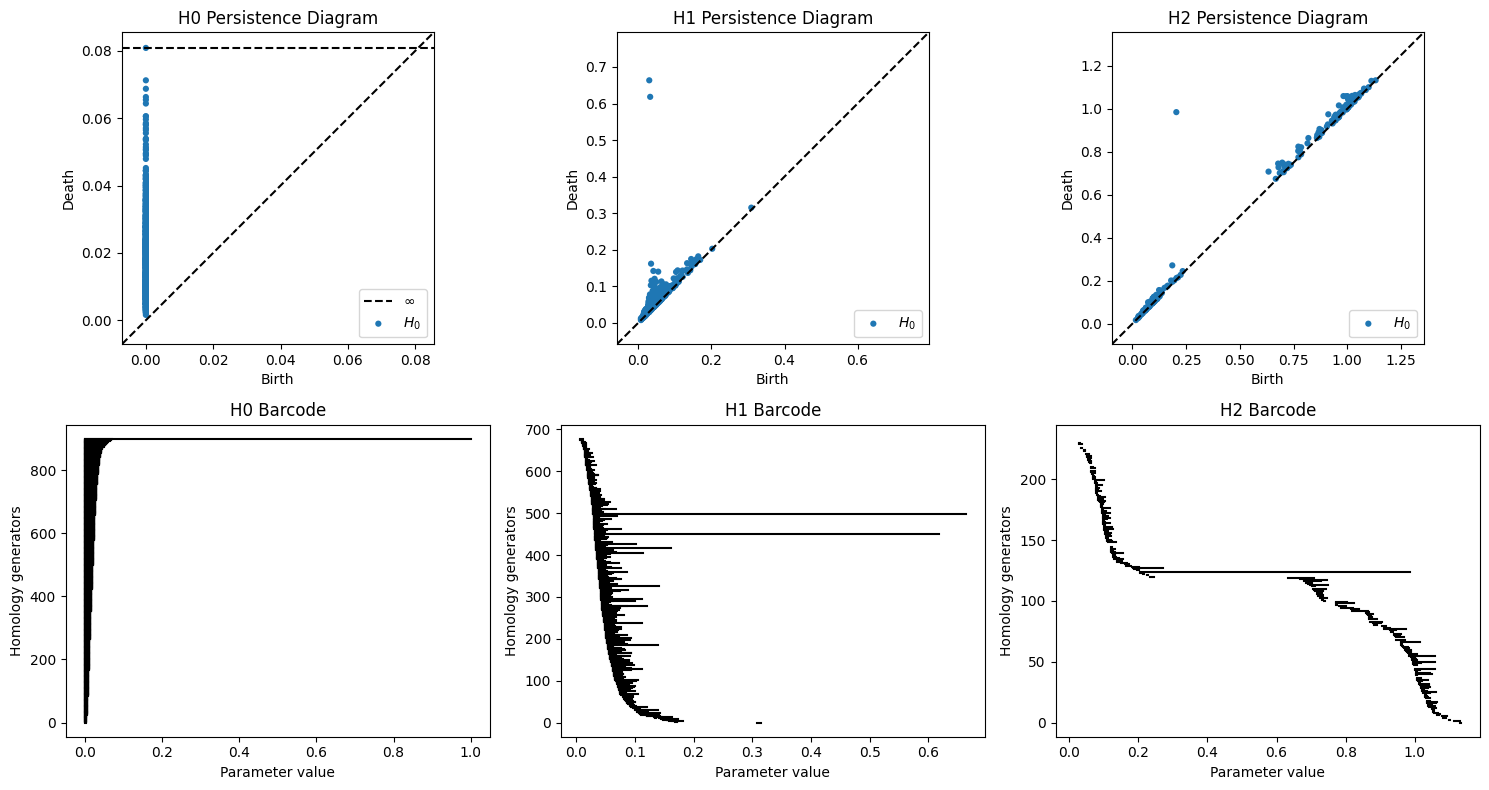

In [208]:
plot_diagrams_and_barcodes(diagrams)

In [166]:
extract_central_square(rate_map, 0.3).shape

(512, 196)

Applying PCA to reduce dimensions from 4096 to 7...
Explained variance with 7 components: 53.50%
Applying UMAP to create 3D visualization...


/Users/julianyocum/anaconda3/envs/ganguli/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.

/Users/julianyocum/anaconda3/envs/ganguli/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



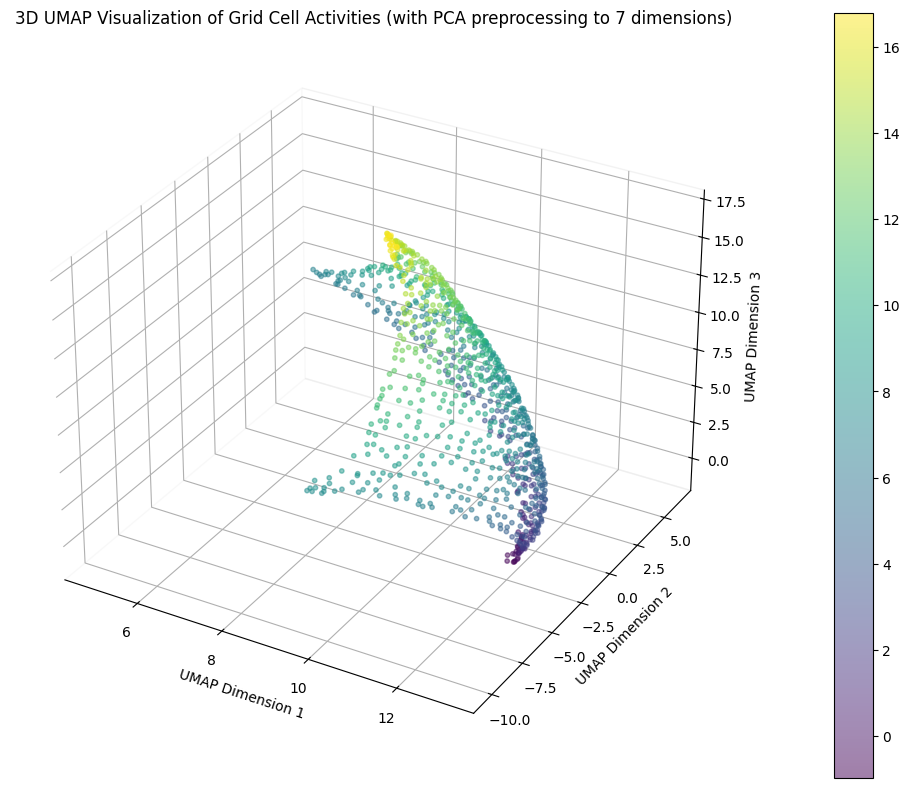

In [188]:
from visualize import visualize_umap_3d, create_interactive_3d_plot

fig, ax, embedding = visualize_umap_3d(extract_central_square(rate_map, 0.6).T, use_pca_first=True, pca_components=7, random_state=42, n_neighbors=15, min_dist=0.5, metric='cosine', init='spectral', n_epochs=1000)
interactive_fig = create_interactive_3d_plot(embedding)
interactive_fig.show()

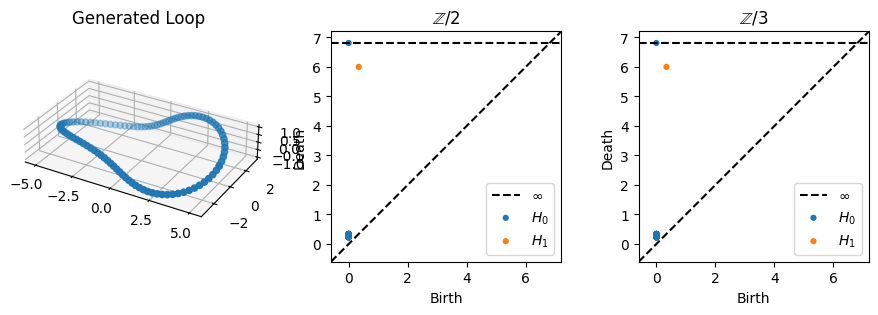

In [12]:
N = 100 # Number of points to sample
R = 4   # Big radius of torus
r = 1   # Little radius of torus
X = np.zeros((N, 3))
t = np.linspace(0, 2*np.pi, N)
X[:, 0] = (R + r*np.cos(2*t))*np.cos(t)
X[:, 1] = (R + r*np.cos(2*t))*np.sin(t)
X[:, 2] = r*np.sin(2*t)

## Step 2: Compute persistent homology
dgms2 = ripser(X, coeff=2)['dgms']
dgms3 = ripser(X, coeff=3)['dgms']

fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(131, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2])
ax.set_aspect('equal')
plt.title("Generated Loop")
plt.subplot(132)
plot_diagrams(dgms2)
plt.title("$\mathbb{Z} / 2$")
plt.subplot(133)
plot_diagrams(dgms3)
plt.title("$\mathbb{Z} / 3$")

plt.tight_layout()
plt.show()


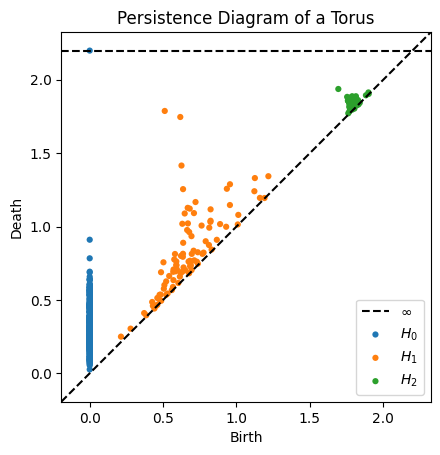

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from ripser import ripser
from persim import plot_diagrams

# Parameters for the torus
R = 2  # large radius (distance from center of tube to center of torus)
r = 1  # small radius (radius of the tube)
n_points = 300  # number of points

# Generate random points on a torus
def sample_torus(n_points, R, r):
    # Sample angles
    theta = 2 * np.pi * np.random.random(n_points)  # around the tube
    phi = 2 * np.pi * np.random.random(n_points)    # around the torus
    
    # Convert to 3D coordinates
    x = (R + r * np.cos(theta)) * np.cos(phi)
    y = (R + r * np.cos(theta)) * np.sin(phi)
    z = r * np.sin(theta)
    
    return np.column_stack((x, y, z))

# Generate point cloud
point_cloud = sample_torus(n_points, R, r)

# Compute persistent homology
result = ripser(point_cloud, maxdim=2)

# Plot persistence diagram
plt.title('Persistence Diagram of a Torus')
diagrams = result['dgms']
plot_diagrams(diagrams, show=True)


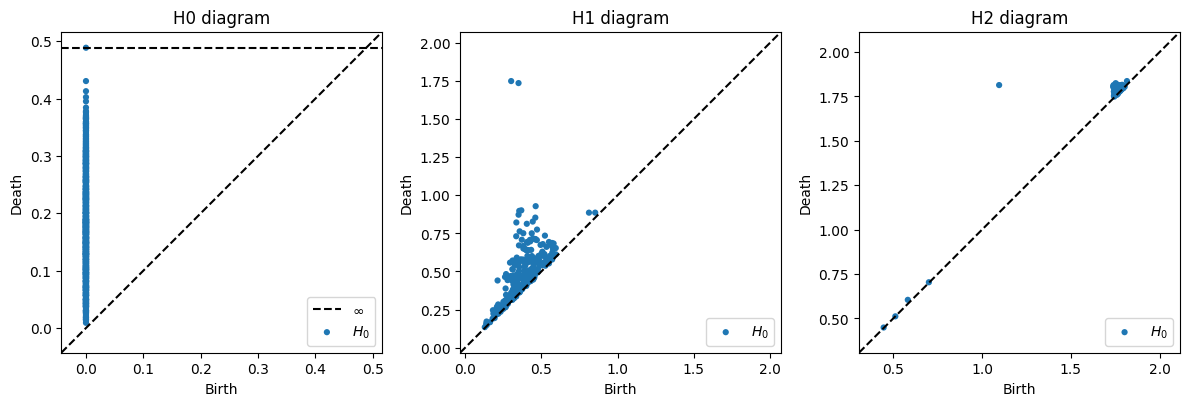

In [57]:
import numpy as np
from ripser import ripser
from persim import plot_diagrams
import matplotlib.pyplot as plt

def sample_torus(n_points=400, R=2.0, r=1.0, seed=None):
    """
    Sample points on a torus in 3D space.

    Parameters:
    -----------
    n_points : int
        Number of points to sample on the torus.
    R : float
        Distance from the center of the hole to the center of the tube.
    r : float
        Radius of the tube.
    seed : int or None
        Random seed for reproducibility.

    Returns:
    --------
    torus_points : ndarray of shape (n_points, 3)
        Sampled points on the torus.
    """
    if seed is not None:
        np.random.seed(seed)
    # Random angles
    theta = 2.0 * np.pi * np.random.rand(n_points)
    phi = 2.0 * np.pi * np.random.rand(n_points)
    
    # Parametric equations for the torus:
    # x = (R + r*cos(phi)) * cos(theta)
    # y = (R + r*cos(phi)) * sin(theta)
    # z = r * sin(phi)
    x = (R + r * np.cos(phi)) * np.cos(theta)
    y = (R + r * np.cos(phi)) * np.sin(theta)
    z = r * np.sin(phi)
    
    torus_points = np.vstack((x, y, z)).T
    return torus_points

# 1. Generate a point cloud for the torus
X = sample_torus(n_points=1000, R=2.0, r=1.0, seed=42)

# 2. Compute persistent homology
#    maxdim=2 will compute H0, H1, and H2
results = ripser(X, maxdim=2)

# 3. Extract the persistence diagrams
diagrams = results['dgms']

# 4. Plot the diagrams
plt.figure(figsize=(12, 4))

for i, diagram in enumerate(diagrams):
    plt.subplot(1, 3, i+1)
    plot_diagrams(diagram, show=False)
    plt.title(f"H{i} diagram")

plt.tight_layout()
plt.show()